<a href="https://colab.research.google.com/github/sowjanya0816/Reddit-Stock-Analysis/blob/main/stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install asyncpraw nltk scikit-learn seaborn matplotlib


In [7]:
import asyncpraw
import nltk
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.sentiment import SentimentIntensityAnalyzer


In [8]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
# Preprocessing function to clean the text
def preprocess_text(text):
    print("Original Text: ", text)  # Debug: Print original text
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    print("Cleaned Text: ", text)  # Debug: Print cleaned text
    text = text.lower()  # Convert to lowercase
    words = nltk.word_tokenize(text)  # Tokenize text
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word not in stopwords]  # Remove stopwords
    return ' '.join(words)

# Test preprocessing function
test_text = "Hello World! This is a test."
print(preprocess_text(test_text))


Original Text:  Hello World! This is a test.
Cleaned Text:  Hello World This is a test
hello world test


In [10]:
# Sentiment analysis function using VADER
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(text)
    print(f"Sentiment Score: {sentiment_score}")  # Debug: Print sentiment score
    return sentiment_score['compound']

# Test sentiment function
test_sentiment = get_sentiment("I love this product!")
print(test_sentiment)


Sentiment Score: {'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696}
0.6696


In [11]:
# Async function to fetch Reddit data
async def fetch_data():
    # Initialize Reddit API client (add your own credentials)
    reddit = asyncpraw.Reddit(client_id='PWnlyKeGUvy09TNuMvkZtQ',
                              client_secret='unKM5mrVlmOVCPo4s5NQCCq4VlRH1w',
                              user_agent='stock_analysis_app/1.0')

    # Fetch posts from subreddit
    subreddit = await reddit.subreddit('stocks')
    posts = []
    async for submission in subreddit.new(limit=10):
        posts.append((submission.title, submission.selftext, submission.score))

    await reddit.close()  # Close the session to avoid unclosed session errors
    print(f"Fetched {len(posts)} posts.")  # Debug: Print number of posts fetched
    return posts

# Run async function to fetch data
import asyncio
posts_data = asyncio.run(fetch_data())
print(posts_data[:3])  # Debug: Print first 3 posts


Fetched 10 posts.
[('PPTA – Antimony play, Space Race and ROD imminent (Dec 2024)', "Perpetua Resources (PPTA) is at a critical juncture in its development of the Stibnite Gold Project, which has the potential to become one of the U.S.'s only domestic sources of antimony. This is a timely opportunity, especially in light of China's recent ban on antimony exports, which is heightening the strategic importance of U.S. production. With the **Record of Decision (ROD)** expected any day now, PPTA’s stock could see significant movement depending on how the situation unfolds.\n\n**The Importance of Antimony and the Global Market Shift**\n\nAntimony is a critical mineral used in everything from flame retardants, space technology, and batteries, and the U.S. has been largely dependent on imports to meet its needs. Until recently, China has been the dominant supplier of antimony. However, as of November 2024, China has imposed restrictions on the export of certain critical minerals, including an

In [12]:
# Process the fetched Reddit data into a DataFrame
processed_data = []
for post in posts_data:
    title, body, upvotes = post
    processed_title = preprocess_text(title)
    processed_body = preprocess_text(body)
    title_sentiment = get_sentiment(processed_title)
    body_sentiment = get_sentiment(processed_body)

    title_word_count = len(processed_title.split())
    body_word_count = len(processed_body.split())
    title_stock_mentions = processed_title.count('stock')
    body_stock_mentions = processed_body.count('stock')

    processed_data.append([processed_title, processed_body, title_sentiment,
                           body_sentiment, title_word_count, body_word_count,
                           title_stock_mentions, body_stock_mentions, upvotes])

# Create DataFrame
columns = ['Processed_Title', 'Processed_Body', 'Title_Sentiment', 'Body_Sentiment',
           'Title_Word_Count', 'Body_Word_Count', 'Title_Stock_Mentions',
           'Body_Stock_Mentions', 'Upvotes']
df = pd.DataFrame(processed_data, columns=columns)

# Display DataFrame
print(df.head())


Original Text:  PPTA – Antimony play, Space Race and ROD imminent (Dec 2024)
Cleaned Text:  PPTA  Antimony play Space Race and ROD imminent Dec 
Original Text:  Perpetua Resources (PPTA) is at a critical juncture in its development of the Stibnite Gold Project, which has the potential to become one of the U.S.'s only domestic sources of antimony. This is a timely opportunity, especially in light of China's recent ban on antimony exports, which is heightening the strategic importance of U.S. production. With the **Record of Decision (ROD)** expected any day now, PPTA’s stock could see significant movement depending on how the situation unfolds.

**The Importance of Antimony and the Global Market Shift**

Antimony is a critical mineral used in everything from flame retardants, space technology, and batteries, and the U.S. has been largely dependent on imports to meet its needs. Until recently, China has been the dominant supplier of antimony. However, as of November 2024, China has impos

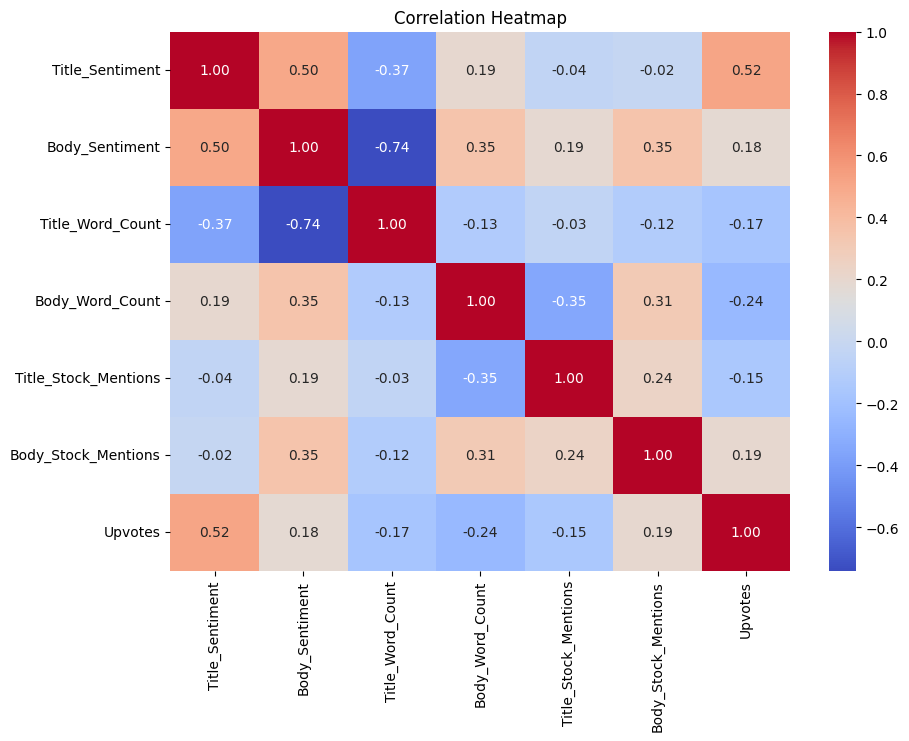

In [13]:
# Correlation heatmap for visualization
if not df.empty:
    corr_matrix = df[['Title_Sentiment', 'Body_Sentiment', 'Title_Word_Count',
                      'Body_Word_Count', 'Title_Stock_Mentions', 'Body_Stock_Mentions', 'Upvotes']].corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("DataFrame is empty, skipping correlation heatmap.")


In [14]:
# Prepare features (X) and target variable (y)
X = df[['Title_Sentiment', 'Body_Sentiment', 'Title_Word_Count', 'Body_Word_Count',
        'Title_Stock_Mentions', 'Body_Stock_Mentions']]
y = df['Upvotes']

# Check the shapes of X and y
print("Features (X) shape: ", X.shape)
print("Target (y) shape: ", y.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Features (X) shape:  (10, 6)
Target (y) shape:  (10,)


In [15]:
# Initialize the model and train it
model = LinearRegression()
model.fit(X_train, y_train)

# Test prediction
y_pred = model.predict(X_test)
print(f"Predictions on Test Set: {y_pred[:5]}")  # Print first 5 predictions


Predictions on Test Set: [-283.0462581   115.48892048]


In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 56094.416886680185
R-squared: -691.5236652676566


In [17]:
# Save the trained model
with open('stock_sentiment_predictor.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved successfully.")


Model saved successfully.


In [20]:
import pandas as pd
import joblib

# Load the trained model
loaded_model = joblib.load('stock_sentiment_predictor.pkl')

# Example input for prediction (ensure it has the same structure as the training data)
example_input = {
    'Title_Sentiment': [0.1],              # Example sentiment score for title
    'Body_Sentiment': [0.2],               # Example sentiment score for body
    'Title_Word_Count': [5],               # Example word count for title
    'Body_Word_Count': [10],               # Example word count for body
    'Title_Stock_Mentions': [1],           # Example number of stock mentions in title
    'Body_Stock_Mentions': [0]             # Example number of stock mentions in body
}

# Convert to a DataFrame with the same columns as during training
example_df = pd.DataFrame(example_input)

# Make prediction using the trained model
example_pred = loaded_model.predict(example_df)

# Output the prediction
print(f"Example Prediction: {example_pred}")


Example Prediction: [-663.0035683]


In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assume y_test and y_pred are your actual and predicted values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Root Mean Squared Error: {rmse}')


Mean Squared Error: 56094.416886680185
R-squared: -691.5236652676566
Root Mean Squared Error: 236.84259939183278
